# FIONA vs GLoW Validation

This notebook compares the amplification factor $F(\omega)$ computed by **FIONA** (this package)
against the reference implementation in the **GLoW** package.

Two scenarios are validated:

1. **Axisymmetric case** — a single SIS lens centred on the origin, solved with `FresnelNUFHT`.
2. **General (non-axisymmetric) case** — a composite of 4 randomly placed SIS sub-lenses,
   solved with `FresnelNUFFT3`.

Both methods should agree on $|F(\omega)|$ up to a global phase, which is removed before plotting.

## 1. Environment Setup

FIONA caches 2-D Gauss–Legendre quadrature grids on disk.  
Set `FIONA_GL2D_DIR` to a writable directory **before** importing FIONA so the cache is found (or created) correctly.

In [12]:
%matplotlib inline

import os

# Point FIONA at the GL2D cache directory.
# Override this path to match your local setup.
GL2D_DIR = (
    os.environ.get("FIONA_GL2D_DIR")
    or "/n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d"
)
os.environ["FIONA_GL2D_DIR"] = GL2D_DIR
os.environ.setdefault("FIONA_GL2D_STRICT", "0")

print("FIONA_GL2D_DIR =", os.environ["FIONA_GL2D_DIR"])

FIONA_GL2D_DIR = /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d


## 2. Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# FIONA
from fiona import SIS, set_num_threads, FresnelNUFHTBatched, FresnelNUFFT3
from fiona.utils import spline_fit_eval, align_global_phase

# GLoW
from glow import lenses as glow_lenses
from glow import time_domain_c, freq_domain_c

# Use up to 112 threads (adjust to your hardware)
set_num_threads(112)

## 3. Default Parameters

### 3.1 `FresnelNUFHT` (axisymmetric solver)

Default keyword arguments for the axisymmetric Hankel-transform solver.

In [14]:
def default_fresnel_nufht_kwargs():
    """Return a dictionary of default FresnelNUFHTBatched constructor arguments."""
    return dict(
        min_physical_radius=0.01,
        adaptive_n_gl=True,
        tol=1e-9,
        n_workers=112,
    )

### 3.2 `FresnelNUFFT3` (general 2-D solver)

Default keyword arguments for the 2-D NUFFT solver.

In [15]:
def default_fresnel_nufft3_kwargs():
    """Return a dictionary of default FresnelNUFFT3 constructor arguments."""
    return dict(
        # Quadrature
        gl_nodes_per_dim=128,
        min_physical_radius=0.0001,
        nufft_tol=1e-9,

        # Frequency batching
        batch_frequencies=True,
        chunk_frequencies=True,
        frequency_binning="log",    # "log" or "linear"
        frequency_bin_width=0.5,    # decades (log) or |ω| units (linear)

        # Adaptive integration domain
        auto_R_from_gl_nodes=True,
        use_tail_correction=True,

        # Windowing
        window_potential=True,
        window_radius_fraction=0.75,
        window_u=True,
        window_u_width=0.02,

        # Coordinate system
        coordinate_system="cartesian",   # "cartesian" or "polar"
        polar_radial_nodes=None,
        polar_angular_nodes=None,
        uniform_angular_sampling=True,

        # Threading
        numexpr_nthreads=None,
        parallel_frequencies=True,
        nufft_workers=None,
        nufft_nthreads=1,

        # NUFFT tiling
        nufft_tile_max_points=4000**2,
        nufft_tile_autotune=True,
        nufft_tile_candidates=(500_000, 1_000_000, 2_000_000, 4_000_000),

        # Type-1 grid path
        use_type1_grid=True,
        type1_interpolate=True,
        type1_max_batch=3,
        type1_iflag=1,
        type1_fftshift=False,
        type1_modeord=1,
        type1_output="ygrid",   # "ygrid" or "kgrid"

        # Miscellaneous
        verbose=True,
    )

## 4. Shared Utilities

### 4.1 Plotting Helper

In [16]:
def _plot_comparison(
    w_grid,
    mag_fiona,
    mag_glow,
    title,
    spline=False,
    spline_method="smooth",
    spline_s=None,
    fine_factor=10,
    font_size=15,
):
    """Plot |F(ω)| for FIONA vs GLoW on a single axes."""
    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": font_size,
    })
    fig, ax = plt.subplots(figsize=(6, 4))

    if spline and w_grid.size >= 4:
        ws_fine = np.linspace(w_grid.min(), w_grid.max(),
                              max(w_grid.size * fine_factor, 200))
        mag_fiona_s = spline_fit_eval(w_grid, mag_fiona, ws_fine,
                                      method=spline_method, smooth_s=spline_s)
        mag_glow_s  = spline_fit_eval(w_grid, mag_glow,  ws_fine,
                                      method=spline_method, smooth_s=spline_s)
        ax.plot(ws_fine, mag_fiona_s, "-",  label="FIONA", color="teal")
        ax.plot(ws_fine, mag_glow_s,  "--", label="GLoW",  color="royalblue")
    else:
        ax.plot(w_grid, mag_fiona, "-",  label="FIONA", color="teal")
        ax.plot(w_grid, mag_glow,  "--", label="GLoW",  color="royalblue")

    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel(r"$|F(\omega)|$")
    ax.set_title(title)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

## 5. Axisymmetric Validation — Single SIS

### 5.1 Comparison Function

Evaluates $F(\omega)$ for a **single SIS** lens at the origin using FIONA's axisymmetric
Hankel-transform solver (`FresnelNUFHT`) and GLoW, then plots $|F(\omega)|$.

In [17]:
def compare_axisym_vs_glow(
    w_grid=np.linspace(0.1, 10.0, 560),
    # Lens parameters
    psi0=1.0,
    # Source position
    y_star=1.0,
    # FresnelNUFHTBatched solver parameters
    min_physical_radius=0.01,
    adaptive_n_gl=True,
    tol=1e-9,
    n_workers=112,
    # Plotting options
    align_phase=True,
    spline=False,
    spline_method="smooth",
    spline_s=None,
    fine_factor=10,
    font_size=15,
):
    """
    Compare FIONA (FresnelNUFHTBatched) and GLoW amplification factors for a
    single axisymmetric SIS lens centred on the origin.

    Parameters
    ----------
    w_grid : array-like
        Frequencies ω at which F(ω) is evaluated.
    psi0 : float
        Einstein radius of the SIS.
    y_star : float
        Source position along the x1 axis, i.e. y = (y_star, 0).
    min_physical_radius : float
        Minimum physical radius for FresnelNUFHTBatched.
    adaptive_n_gl : bool
        If True, use adaptive GL node count per frequency bin.
    tol : float
        Tolerance for FresnelNUFHTBatched.
    n_workers : int
        Number of parallel worker processes for FresnelNUFHTBatched.
    align_phase : bool
        If True, rotate F_fiona to minimise the global phase difference with F_glow.
    spline : bool
        If True, plot smoothed spline curves instead of the raw discrete points.
    spline_method : str
        Spline method passed to :func:`fiona.utils.spline_fit_eval`.
    spline_s : float, optional
        Smoothing factor for ``spline_method='smooth'``.
    fine_factor : int
        Oversampling factor for the spline evaluation grid.
    font_size : int
        Base font size for the plot.

    Returns
    -------
    F_fiona : ndarray, complex
        Amplification factor from FIONA at each frequency in w_grid.
    F_glow : ndarray, complex
        Amplification factor from GLoW at each frequency in w_grid.
    """
    w_grid = np.asarray(w_grid, dtype=float)

    # ------------------------------------------------------------------
    # Build lens (single SIS at origin)
    # ------------------------------------------------------------------
    lens = SIS(psi0=psi0)

    # ------------------------------------------------------------------
    # FIONA: evaluate F(ω) with the parallelised batched axisymmetric solver
    # ------------------------------------------------------------------
    solver = FresnelNUFHTBatched(
        lens,
        min_physical_radius=min_physical_radius,
        adaptive_n_gl=adaptive_n_gl,
        tol=tol,
        n_workers=n_workers,
    )
    F_arr  = solver(w_grid, np.array([y_star]))  # shape (n_w, 1)
    F_fiona = F_arr[:, 0]                         # shape (n_w,)

    # ------------------------------------------------------------------
    # GLoW: evaluate F(ω) via FFT of the time-domain amplification factor
    # ------------------------------------------------------------------
    Psi    = glow_lenses.Psi_SIS({"psi0": float(psi0)}, {})
    It     = time_domain_c.It_MultiContour_C(Psi, y=float(y_star))
    Fw     = freq_domain_c.Fw_FFT_C(It)
    F_glow = Fw(w_grid)

    # ------------------------------------------------------------------
    # Plot |F(ω)|
    # ------------------------------------------------------------------
    F_fiona_plot = align_global_phase(F_fiona, F_glow)[0] if align_phase else F_fiona
    _plot_comparison(
        w_grid, np.abs(F_fiona_plot), np.abs(F_glow),
        title=rf"SIS @ $y=({y_star},\,0)$",
        spline=spline, spline_method=spline_method, spline_s=spline_s,
        fine_factor=fine_factor, font_size=font_size,
    )

    return F_fiona, F_glow

### 5.2 Run Comparisons

We use a single SIS lens with `psi0=1` and evaluate $F(\omega)$ for three source
positions: $y = 0.25$, $0.5$, and $1.0$.

In [18]:
axisym_kwargs = default_fresnel_nufht_kwargs()

AXISYM_COMMON = dict(
    w_grid=np.linspace(0.1, 50.0, 560),
    psi0=1.0,
    **axisym_kwargs,
)

#### 5.2.1  Source at $y = 0.25$

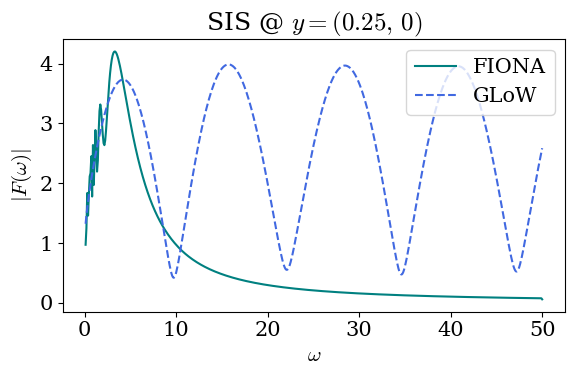

In [19]:
F_axisym_025, F_glow_axisym_025 = compare_axisym_vs_glow(y_star=0.25, **AXISYM_COMMON)

#### 5.2.2  Source at $y = 0.5$

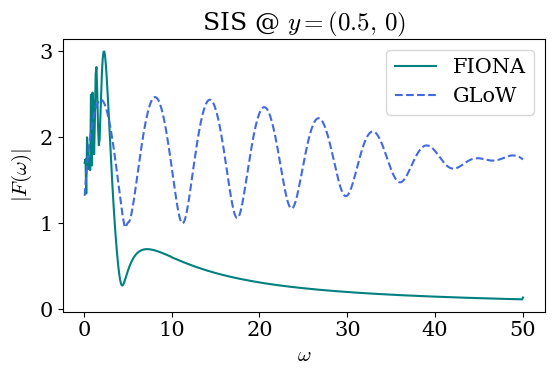

In [20]:
F_axisym_050, F_glow_axisym_050 = compare_axisym_vs_glow(y_star=0.5, **AXISYM_COMMON)

#### 5.2.3  Source at $y = 1.0$

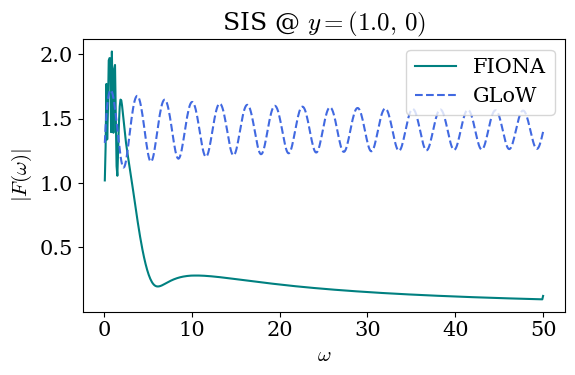

In [21]:
F_axisym_100, F_glow_axisym_100 = compare_axisym_vs_glow(y_star=1.0, **AXISYM_COMMON)

## 6. General Case Validation — 4×SIS

### 6.1 Lens Models

#### 6.1.1 Random SIS Composite Lens (FIONA side)

In [22]:
class RandomSISLens:
    """
    A composite gravitational lens consisting of `n` SIS sub-lenses placed
    at random positions within a square of half-side `spread`, centred on the
    origin.

    Parameters
    ----------
    n : int
        Number of SIS sub-lenses.
    psi0 : float
        Einstein radius of each individual SIS.
    spread : float
        Half-width of the uniform square from which positions are drawn.
    seed : int
        Random seed for reproducibility.
    """

    def __init__(self, n=10, psi0=1.0, spread=0.8, seed=123):
        rng = np.random.default_rng(seed)
        self.n = n
        self.psi0 = psi0

        positions = rng.uniform(-spread, spread, size=(n, 2))
        # Centre-of-mass correction so the lens cluster is centred on the origin
        self.positions = positions - positions.mean(axis=0)

        self.lenses = [SIS(psi0=psi0) for _ in range(n)]

    def psi_xy(self, x1, x2):
        """Evaluate the combined lensing potential at position (x1, x2)."""
        psi = 0.0
        for lens, (dx, dy) in zip(self.lenses, self.positions):
            psi = psi + lens.psi_xy(x1 - dx, x2 - dy)
        return psi


def make_glow_composite_lens(random_sis_lens):
    """
    Convert a :class:`RandomSISLens` into an equivalent GLoW ``CombinedLens``.

    Parameters
    ----------
    random_sis_lens : RandomSISLens
        The FIONA-side lens object.

    Returns
    -------
    glow.lenses.CombinedLens
        A GLoW composite lens with the same sub-lens positions and strengths.
    """
    components = [
        glow_lenses.Psi_offcenterSIS(
            {"psi0": float(random_sis_lens.psi0), "xc1": float(dx), "xc2": float(dy)},
            {},
        )
        for dx, dy in random_sis_lens.positions
    ]
    return glow_lenses.CombinedLens({"lenses": components}, {})

### 6.2 Comparison Function

Evaluates $F(\omega)$ with both FIONA (`FresnelNUFFT3`) and GLoW for the same composite
SIS lens, then plots $|F(\omega)|$ as a function of $\omega$.

In [23]:
def compare_fiona_vs_glow(
    w_grid=np.linspace(0.1, 10.0, 560),
    # Lens parameters
    n_sis=10,
    psi0=1.0,
    spread=7.0,
    seed=123,
    # Source position
    y_star=1.0,
    # FIONA solver parameters (overrides defaults)
    fiona_kwargs=None,
    # Plotting options
    align_phase=True,
    spline=False,
    spline_method="smooth",
    spline_s=None,
    fine_factor=10,
    font_size=15,
):
    """
    Compare FIONA and GLoW amplification factors for a composite SIS lens.

    Parameters
    ----------
    w_grid : array-like
        Frequencies ω at which F(ω) is evaluated.
    n_sis : int
        Number of SIS sub-lenses.
    psi0 : float
        Einstein radius of each SIS.
    spread : float
        Half-width of the region where sub-lenses are placed.
    seed : int
        Random seed (fixes the lens realisation).
    y_star : float
        Source position along the x1 axis, i.e. y = (y_star, 0).
    fiona_kwargs : dict, optional
        Keyword arguments forwarded to FresnelNUFFT3, overriding the defaults.
    align_phase : bool
        If True, rotate F_fiona to minimise the global phase difference with F_glow.
    spline : bool
        If True, plot smoothed spline curves instead of the raw discrete points.
    spline_method : str
        Spline method passed to :func:`fiona.utils.spline_fit_eval`.
    spline_s : float, optional
        Smoothing factor for ``spline_method='smooth'``.
    fine_factor : int
        Oversampling factor for the spline evaluation grid.
    font_size : int
        Base font size for the plot.

    Returns
    -------
    F_fiona : ndarray, complex
        Amplification factor from FIONA at each frequency in w_grid.
    F_glow : ndarray, complex
        Amplification factor from GLoW at each frequency in w_grid.
    fk : dict
        The FresnelNUFFT3 keyword arguments actually used.
    """
    w_grid = np.asarray(w_grid, dtype=float)

    # ------------------------------------------------------------------
    # Build lens
    # ------------------------------------------------------------------
    lens = RandomSISLens(n=n_sis, psi0=psi0, spread=spread, seed=seed)

    # ------------------------------------------------------------------
    # FIONA: evaluate F(ω) on a small grid centred on (y_star, 0)
    # and extract the central pixel
    # ------------------------------------------------------------------
    fk = default_fresnel_nufft3_kwargs()
    if fiona_kwargs:
        fk.update(fiona_kwargs)

    solver = FresnelNUFFT3(lens, **fk)

    # Small uniform grid around (y_star, 0) — the central pixel gives F at (y_star, 0)
    y1_axis = np.linspace(y_star - 0.05, y_star + 0.05, 33)
    y2_axis = np.linspace(-0.05, 0.05, 33)
    Y1, Y2 = np.meshgrid(y1_axis, y2_axis, indexing="xy")

    Fw_grid = solver(w_grid, Y1, Y2)            # shape (n_freq, 33, 33)
    iy = len(y2_axis) // 2
    ix = len(y1_axis) // 2
    F_fiona = Fw_grid[:, iy, ix]                # shape (n_freq,)

    # ------------------------------------------------------------------
    # GLoW: evaluate F(ω) via FFT of the time-domain amplification factor
    # ------------------------------------------------------------------
    Psi    = make_glow_composite_lens(lens)
    It     = time_domain_c.It_MultiContour_C(Psi, y=float(y_star))
    Fw     = freq_domain_c.Fw_FFT_C(It)
    F_glow = Fw(w_grid)

    # ------------------------------------------------------------------
    # Plot |F(ω)|
    # ------------------------------------------------------------------
    F_fiona_plot = align_global_phase(F_fiona, F_glow)[0] if align_phase else F_fiona
    _plot_comparison(
        w_grid, np.abs(F_fiona_plot), np.abs(F_glow),
        title=rf"{n_sis}$\times$SIS @ $y=({y_star},\,0)$",
        spline=spline, spline_method=spline_method, spline_s=spline_s,
        fine_factor=fine_factor, font_size=font_size,
    )

    return F_fiona, F_glow, fk

### 6.3 Run Comparisons

We use a composite lens of **4 SIS sub-lenses** with `spread=2` and evaluate $F(\omega)$
for three source positions: $y = 0.25$, $0.5$, and $1.0$.

#### FIONA solver settings

In [7]:
fiona_kwargs = default_fresnel_nufft3_kwargs()
fiona_kwargs.update(
    dict(
        gl_nodes_per_dim=1000,
        min_physical_radius=10.0,
        nufft_tol=1e-9,
        auto_R_from_gl_nodes=True,
        use_tail_correction=True,
        # Windowing disabled for this comparison
        window_potential=False,
        window_u=False,
        window_radius_fraction=0.75,
        window_u_width=0.02,
        coordinate_system="cartesian",
        numexpr_nthreads=1,
        parallel_frequencies=True,
        nufft_workers=112,
        nufft_nthreads=1,
        nufft_tile_max_points=4000**2,
        nufft_tile_autotune=True,
        nufft_tile_candidates=(500_000, 1_000_000, 2_000_000, 4_000_000,
                               6_000_000, 8_000_000),
        use_type1_grid=False,
        type1_interpolate=False,
        type1_max_batch=3,
        type1_iflag=1,
        type1_fftshift=True,
        type1_modeord=1,
        type1_output="ygrid",
        batch_frequencies=True,
        chunk_frequencies=True,
        frequency_binning="log",
        frequency_bin_width=0.5,
        verbose=True,
    )
)

# Shared lens and frequency settings
COMMON = dict(
    w_grid=np.linspace(0.1, 50.0, 560),
    n_sis=4,
    psi0=1.0,
    spread=2.0,
    seed=123,
    fiona_kwargs=fiona_kwargs,
)

#### 6.3.1  Source at $y = 0.25$

[numexpr] using 1 threads (requested=1, MAX=1, cores=112)
[FresnelNUFFT3] x-domain path
  input prep:      0.0002s
  grouping:        0.0024s | groups=6
  adaptive R/h:  R in [7.07739, 70.7107] | n_gl in [1000, 6000], h in [0.0444288, 0.443892]
  quadrature:      0.2427s
  lens + base:     0.0000s
  scaling:         0.0000s
  alloc out:       0.0001s
  NUFFT total:    36.4826s
  tiling:        adaptive (tiles in [1, 72], max_points=16000000)
  workers:       up to 112 (nufft_nthreads=1)
  wall total:     41.9943s


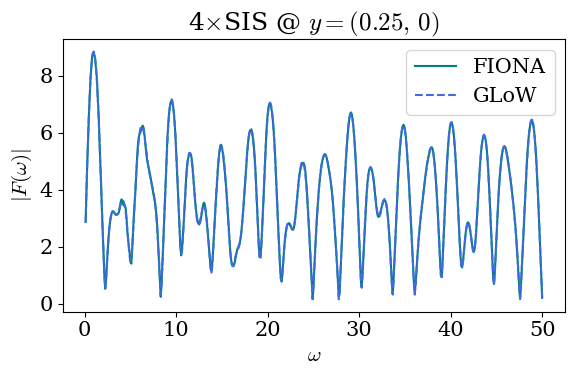

In [8]:
F_fiona_025, F_glow_025, _ = compare_fiona_vs_glow(y_star=0.25, **COMMON)

#### 6.3.2  Source at $y = 0.5$

[numexpr] using 1 threads (requested=1, MAX=1, cores=112)
[FresnelNUFFT3] x-domain path
  input prep:      0.0001s
  grouping:        0.0023s | groups=6
  adaptive R/h:  R in [7.07739, 70.7107] | n_gl in [1000, 6000], h in [0.0444288, 0.443892]
  quadrature:      0.1875s
  lens + base:     0.0000s
  scaling:         0.0000s
  alloc out:       0.0000s
  NUFFT total:    38.3197s
  tiling:        adaptive (tiles in [1, 72], max_points=16000000)
  workers:       up to 112 (nufft_nthreads=1)
  wall total:     43.8608s


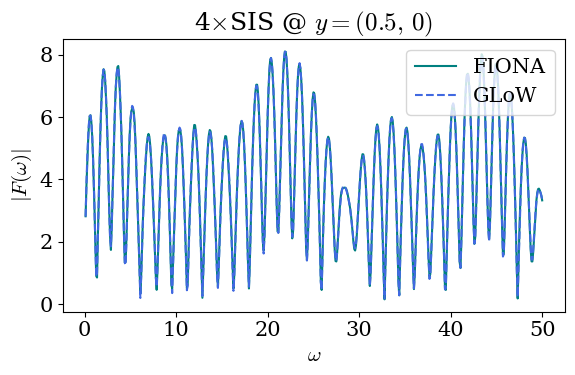

In [9]:
F_fiona_050, F_glow_050, _ = compare_fiona_vs_glow(y_star=0.5, **COMMON)

#### 6.3.3  Source at $y = 1.0$

[numexpr] using 1 threads (requested=1, MAX=1, cores=112)
[FresnelNUFFT3] x-domain path
  input prep:      0.0001s
  grouping:        0.0010s | groups=6
  adaptive R/h:  R in [7.07739, 70.7107] | n_gl in [1000, 6000], h in [0.0444288, 0.443892]
  quadrature:      0.2803s
  lens + base:     0.0000s
  scaling:         0.0000s
  alloc out:       0.0000s
  NUFFT total:    39.8284s
  tiling:        adaptive (tiles in [1, 72], max_points=16000000)
  workers:       up to 112 (nufft_nthreads=1)
  wall total:     45.4293s


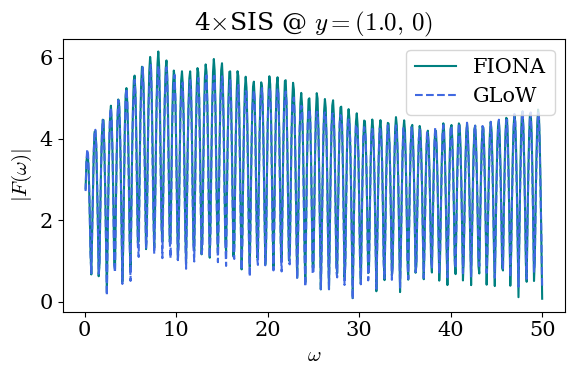

In [10]:
F_fiona_100, F_glow_100, _ = compare_fiona_vs_glow(y_star=1.0, **COMMON)